### パイプライン

In [1]:
# データセット読み込み
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)

In [2]:
# クラスラベルを数値にエンコーディング
from sklearn.preprocessing import LabelEncoder
X = df.loc[:, 2:].values # 3項目目以降が特徴量(30次元)
y = df.loc[:, 1].values  # 2項目目がクラスラベル(Bが良性、Mが悪性)
le = LabelEncoder()
y = le.fit_transform(y)
# 変換されたことを確認(0から順にエンコードされた値を表示する)
le.classes_

array(['B', 'M'], dtype=object)

In [3]:
# データをテストデータとトレーニングデータに分割
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

以下ではパイプライン関数を用いて、2つの前処理とモデル適合を順番に行う例を示す
1. ロジスティック回帰に入力するための標準化
2. データを30次元から2次元に圧縮する主成分分析（PCA)
3. ロジスティック回帰

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
# pipeline関数には、タプルのリストを渡す。タプルのひとつ目の値は任意の文字列、ふたつ目は変換器または推定器
pipe_lr = Pipeline([
        ('scl', StandardScaler()),
        ('pca', PCA(n_components=2)),
        ('clf', LogisticRegression(random_state=1))
    ])
# fitメソッドを実行すると、変換器（scl, pca）では、fit & transformを実行し、次のステップに渡す。最後の推定器（clf）でfitを実行する
pipe_lr.fit(X_train, y_train)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

Test Accuracy: 0.947


### k分割交差検証

* モデル選択…パラメータをチューニングし、最適な値を選択する分類問題を指す
* ハイパーパラメータ…トレーニングデータにより学習されるものではなく、個別に設定が必要なもの
* ホールドアウト法…トレーニングデータを、トレーニング用とテスト用に分割しモデルの汎化性能を評価する方法<br>
パラメータチューニングの性能検証（モデル選択）に使ったデータで性能も評価しようとすると、過学習でバリアンスが高くなる可能性があるので、<br>
トレーニングデータセット、検証データセット（モデル選択用）、テストデータセット（汎化性能測定用）の3つに分けて、モデル選択と評価を行うと良い
* k分割交差検証…トレーニングセットをランダムにk個に分割、そのうちk-1個（それぞれの学習でk個の内一個が選ばれる）をトレーニングに、<br>1個をテストに使用し、(非復元抽出)これをk回繰り返す方法<br>非復元抽出のため、同じデータが繰り返しあらわれることがないので、ホールドアウト法よりバリアンスが低い<br>k回のイテレーションのそれぞれでモデルの性能$E_i$が評価され、それを平均した$E=\frac{1}{10}\sum_{i=1}^{10}E_i$がモデルの推定性能となる
* kの値…一般的に用いられるkの値は10だが小さい場合は5にするなどの工夫も有効
* 層化k分割交差検証…各サブセットにおいてクラスの比率が維持される

In [5]:
# k分割交差検証の改善版、層化k分割交差検証を実行
import numpy as np
from sklearn.cross_validation import StratifiedKFold
# kfoldクラスのインスタンス化
kfold = StratifiedKFold(y=y_train, n_folds=10, random_state=1)

# 分割したデータでループ処理を行い、サブセット毎の正解率を出力
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %s, Class dist.: %s, Acc: %.3f' % (k+1, np.bincount(y_train[train]), score))
    
# 平均正解率と標準偏差を表示
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fold: 1, Class dist.: [256 153], Acc: 0.891
Fold: 2, Class dist.: [256 153], Acc: 0.978
Fold: 3, Class dist.: [256 153], Acc: 0.978
Fold: 4, Class dist.: [256 153], Acc: 0.913
Fold: 5, Class dist.: [256 153], Acc: 0.935
Fold: 6, Class dist.: [257 153], Acc: 0.978
Fold: 7, Class dist.: [257 153], Acc: 0.933
Fold: 8, Class dist.: [257 153], Acc: 0.956
Fold: 9, Class dist.: [257 153], Acc: 0.978
Fold: 10, Class dist.: [257 153], Acc: 0.956
CV accuracy: 0.950 +/- 0.029


/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
# 上記はscikit-leanの関数でより簡単に実行できる
from sklearn.cross_validation import cross_val_score
# cvは分割数、利用するCPU数はn_jobs
scores = cross_val_score(estimator=pipe_lr, X=X_train, y=y_train, cv=10, n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [ 0.89130435  0.97826087  0.97826087  0.91304348  0.93478261  0.97777778
  0.93333333  0.95555556  0.97777778  0.95555556]
CV accuracy: 0.950 +/- 0.029


### バイアスとバリアンス

* バイアスが高い…トレーニングでも性能検証でも精度が低く学習不足の状態。追加する特徴量を収集/生成する、正則化の強さを下げるなどパラメータを増やすことで対応する
* バリアンスが高い…トレーニングでは性能が出ているが、性能検証は低い過学習の状態。トレーニングデータをさらにあつめるか、正則化のパラメータを増やす、特徴抽出/選択で次元（自由度）を減らすなど、モデルの複雑化を抑えることで対応する

#### 学習曲線

横軸にトレーニングデータ数、縦軸にトレーニングと検証での正解率をプロットする曲線<br>
モデルのバイアス、バリアンスが高いかや、データを更に集めることが有効かどうかを把握できる

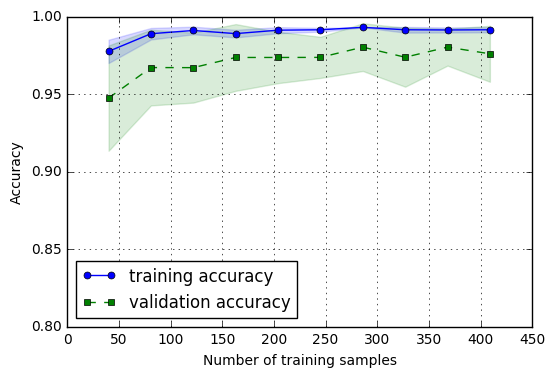

In [7]:
# 学習曲線を使ってモデルを評価する例
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
pipe_lr = Pipeline([
        ('scl', StandardScaler()),
        ('clf', LogisticRegression(penalty='l2', random_state=0))
    ])
# learning_curve関数で、交差検証による正解率を算出
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr,
                                                        X=X_train,
                                                        y=y_train,
                                                        train_sizes=np.linspace(0.1, 1.0, 10), # トレーニングサンプルの数を制御。n回目のサイズ指定は配列のn番目
                                                        cv=10,
                                                        n_jobs=1
                                                       )
# スコアの平均と標準偏差を計算
train_mean = np.mean(train_scores, axis=1) # axis=1 列の平均
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# トレーニングデータのグラフを描画
plt.plot(train_sizes, train_mean, color='b', marker='o', markersize=5, label='training accuracy')
# +-標準偏差分を薄く表示してブレ幅を表現
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='b') # alphaは透明度
# テストデータも同様に表示
plt.plot(train_sizes, test_mean, color='g', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='g')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower left')
plt.ylim([0.8, 1.0])
plt.show()

上記では、トレーニングとバリデーションの正解率曲線の間に隔たりがあることから僅かではあるが過学習があることがわかる

#### 検証曲線

学習曲線と異なり、サンプルサイズではなく、モデルのパラメータを横軸にとり、正解率を縦軸にプロットする<br>
過学習や学習不足の問題を確認することができる

/usr/local/lib/python2.7/dist-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


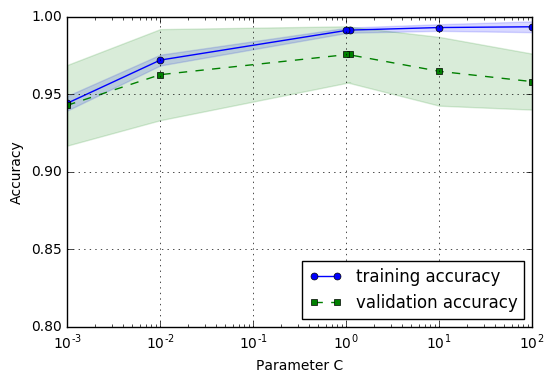

In [8]:
from sklearn.learning_curve import validation_curve
param_range = [0.001, 0.01, 1.1, 1.0, 10.0, 100.0] # 正則化パラメータの逆数（小さいとペナルティーが強い）
train_scores, test_scores = validation_curve(estimator=pipe_lr,
                                             X=X_train,
                                             y=y_train,
                                             param_name='clf__C', # パイプライン内のオプションは識別文字列__パラメータ で指定可能
                                             param_range=param_range,
                                             cv=10
                                            )

# スコアの平均と標準偏差を計算
train_mean = np.mean(train_scores, axis=1) # axis=1 列の平均
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# トレーニングデータのグラフを描画
plt.plot(param_range, train_mean, color='b', marker='o', markersize=5, label='training accuracy')
# +-標準偏差分を薄く表示してブレ幅を表現
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='b') # alphaは透明度
# テストデータも同様に表示
plt.plot(param_range, test_mean, color='g', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='g')

plt.grid()
plt.xscale('log')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()

### グリッドサーチ

指定されたパラメータの組み合わせを用いた学習と評価を網羅的に実施し、モデルを選択していく方法

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
pipe_svc = Pipeline([
        ('scl', StandardScaler()),
        ('clf', SVC(random_state=1))
    ])
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [
    {'clf__C': param_range, 'clf__kernel': ['linear']}, # 線形SVMでは逆正則化パラメータのみ評価
    {'clf__C': param_range, 'clf__gamma': param_range, 'clf__kernel': ['rbf']} # RBFカーネルではgammaも評価
]
# グリッドサーチのクラスをインスタンス化
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy', cv=10, n_jobs=-1)
# 学習
gs = gs.fit(X_train, y_train)

# モデルの最良スコア
print(gs.best_score_)
# 最良スコアとなるパラメータ
print(gs.best_params_)

0.978021978022
{'clf__C': 0.1, 'clf__kernel': 'linear'}


In [10]:
# 以下のように試したそれぞれのパラメータ毎のスコアを表示させることもできる
for params, mean_score, scores in gs.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r" % (mean_score, scores.std(), params))
    
#gs.cv_results_

0.642 (+/-0.017) for {'clf__C': 0.0001, 'clf__kernel': 'linear'}
0.938 (+/-0.024) for {'clf__C': 0.001, 'clf__kernel': 'linear'}
0.960 (+/-0.023) for {'clf__C': 0.01, 'clf__kernel': 'linear'}
0.978 (+/-0.020) for {'clf__C': 0.1, 'clf__kernel': 'linear'}
0.976 (+/-0.023) for {'clf__C': 1.0, 'clf__kernel': 'linear'}
0.971 (+/-0.014) for {'clf__C': 10.0, 'clf__kernel': 'linear'}
0.952 (+/-0.021) for {'clf__C': 100.0, 'clf__kernel': 'linear'}
0.945 (+/-0.030) for {'clf__C': 1000.0, 'clf__kernel': 'linear'}
0.626 (+/-0.004) for {'clf__gamma': 0.0001, 'clf__C': 0.0001, 'clf__kernel': 'rbf'}
0.626 (+/-0.004) for {'clf__gamma': 0.001, 'clf__C': 0.0001, 'clf__kernel': 'rbf'}
0.626 (+/-0.004) for {'clf__gamma': 0.01, 'clf__C': 0.0001, 'clf__kernel': 'rbf'}
0.626 (+/-0.004) for {'clf__gamma': 0.1, 'clf__C': 0.0001, 'clf__kernel': 'rbf'}
0.626 (+/-0.004) for {'clf__gamma': 1.0, 'clf__C': 0.0001, 'clf__kernel': 'rbf'}
0.626 (+/-0.004) for {'clf__gamma': 10.0, 'clf__C': 0.0001, 'clf__kernel': 'rbf'}

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:662: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


最後にトレーニングデータセットから独立したテストデータセットを使い、モデルの性能を評価する

In [11]:
# 最も正解率が高いモデルを取得
clf = gs.best_estimator_
# トレーニング用データ全件を用い、fit
clf.fit(X_train, y_train)
# テスト用データで汎化性能を検証
print('Test accuracy: %.3f' % clf.score(X_test, y_test))

Test accuracy: 0.965


#### 入れ子式の交差検証

様々な機械学習のアルゴリズムからどれかを選択する際に有用な方法<br>
2つのループで構成され、外側のループはk分割交差検証を使って、データをトレーニングセットとテストセットに分割する（cv=5）<br>
内側のループは上記のトレーニングセットに対し更にk分割交差検証を使いデータをトレーニングと検証の2分割（cv=2)にしてモデルを選択する<br>
モデルを選択後、外側のループのテストセットでモデルの性能を評価する

In [12]:
# 内側のループ（ハイパーパラメータ選択）
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy', cv=2, n_jobs=-1)
# 外側のループ（交差検証）
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.965 +/- 0.025


In [13]:
# 決定木でも同じ処理を行い、正解率を比較する
from sklearn.tree import DecisionTreeClassifier
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring='accuracy',
                  cv=2
                 )
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.921 +/- 0.029


SVMと決定木を比較すると、SVMの方が性能が良いことがわかる

#### 混同行列

* 真陽性…陽性と予測しあたった
* 偽陽性…陽性と予測し外れた
* 真陰性…陰性と予測しあたった
* 偽陰性…陰性と予測し外れた

In [14]:
# 混同行列を作成
from sklearn.metrics import confusion_matrix
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
# テストと予測のデータから混合行列を生成
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


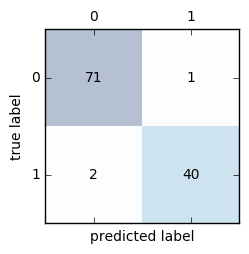

In [15]:
# 可視化
fig, ax = plt.subplots(figsize=(2.5, 2.5))
# matshowで行列からヒートマップを描画
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]): # クラス0の繰り返し処理
    for j in range(confmat.shape[1]): # クラス1の繰り返し処理
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center') # 件数を表示
        
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

#### 適合率と正解率、真陽性率、偽陽性率、適合率、再現率（真陽性率と同義）、F1スコア

誤分類率（ERR）…誤った予測の合計を予測の総数で割ったもの

$$
ERR = \frac{FP + FN}{FP + FN + TP + TN}
$$

正解率（ACC）…正しい予測の合計を予測の総数で割ったもの

$$
ACC = \frac{TP + TN}{FP + FN + TP +TN} = 1 - ERR
$$

偽陽性率（TPR）…すべての陰性の内、間違って陽性と判断した割合　下のTPRと合わせクラスの分布に偏りがある場合に役立つ

$$
FPF = \frac{FP}{N} = \frac{FP}{FP + TN}
$$

真陽性率（TPR）…全陽性のうち、どれだけを正確に予測したか（故障や病気をどれだけ予測できたかなど）

$$
TPR = \frac{TP}{P} = \frac{TP}{FN + TP}
$$

適合率（PRE）…陽性と予測したものの内、実際に陽性だった割合

$$
PRE = \frac{TP}{TP + FP}
$$

再現率（REC）…TPRと同義

$$
REC　= TPR = \frac{TP}{FN + TP}
$$

F1スコア…PREとRECを組み合わせたスコア（適合率と再現率の調和平均）

$$
F1 = 2\frac{PRE \times REC}{PRE + REC}
$$

In [16]:
# 上記の指標はsklearnで実装されている
# 適合率
from sklearn.metrics import precision_score
print ('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))

Precision: 0.976


In [17]:
# 再現率
from sklearn.metrics import recall_score
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))

Recall: 0.952


In [18]:
# F1スコア
from sklearn.metrics import f1_score
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

F1: 0.964


In [19]:
# GridSearchCVオブジェクトでは正解率以外の性能指標を選択可能 scoring引数に指定可能
# make_scorer関数を使って独自の性能評価関数を作ることもできる
from sklearn.metrics import make_scorer, f1_score
scorer = make_scorer(f1_score, pos_label=0)
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring=scorer, cv=10)

#### ROC曲線

受信者操作特性（ROC）曲線…分類器のしきい値をかえ、以下の2軸でプロットをするグラフ

横軸…False Positive Rate 全部の陰性の内、誤って陽性と判断した割合 0に近いほどよい
縦軸…True Positive Rate 全部の陽性の内、陽性と判断した割合 1に近いほどよい

対角線がランダムな推定と解釈でき、それを下回るものは当て推量より悪いとになされる。<br>

分類モデルの性能として、曲線下面積（Area Under the Curve: AUC）が用いられる。

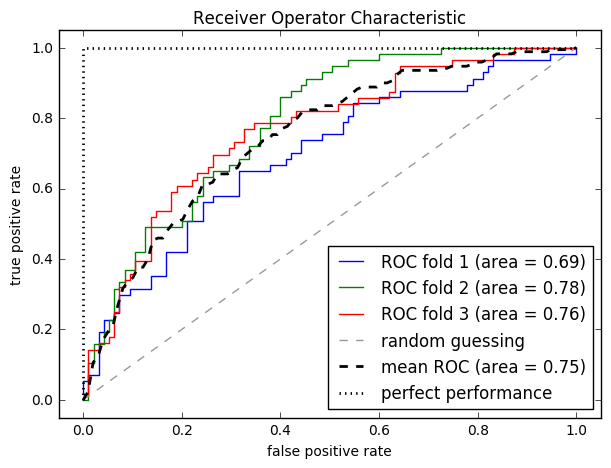

In [20]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
# Pipelineクラスをインスタンス化
pipe_lr = Pipeline([
        ('scl', StandardScaler()),
        ('pca', PCA(n_components=2)),
        ('clf', LogisticRegression(penalty='l2', random_state=0, C=100.0))
        
    ])

# 2つの特徴量を抽出
X_train2 = X_train[:, [4, 14]]
# データを3分割してプロットしてみる
cv = StratifiedKFold(y_train, n_folds=3, random_state=1)
fig = plt.figure(figsize=(7, 5))
mean_tpr = 0.0 # 縦軸
mean_fpr = np.linspace(0, 1, 100) # 横軸
all_tpr = []
for i, (train, test) in enumerate(cv):
    # predict_proba 所属しているクラスになる確率を返す [クラス1の確率, クラス2の確率]
    probas = pipe_lr.fit(X_train2[train], y_train[train]).predict_proba(X_train2[test])
    # fprとtprの対を計算 thresholds = ?
    fpr, tpr, thresholds = roc_curve(y_train[test], probas[:, 1], pos_label=1)
    # aucを計算
    roc_auc = auc(fpr, tpr)
    # グラフにプロット
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i + 1, roc_auc))
    # 後で3分割した値の平均をプロットするための準備
    # 線形補完 引数位置:(値を知りたいX軸の位置, Y軸の値がわかっているX軸の値, 左のX軸に対応するY軸の値)
    mean_tpr += interp(mean_fpr, fpr, tpr) # 1列に3分割ぶんのデータが足し合わされる
    mean_tpr[0] = 0.0

    
# ランダム（正解率50%）の線をプロット
plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='random guessing')

# 3つに分割したデータに対応するFPR, TPR, ROC AUCそれぞれの平均を計算してプロット
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--', label='mean ROC (area = %0.2f)' % mean_auc, lw=2)

# 完全に予測できた場合の線をプロット（fpr=0のときからtprが0）
plt.plot([0, 0, 1], [0, 1, 1], lw=2, linestyle=':', color='black', label='perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc='lower right')
plt.show()

In [21]:
# グラフを描画せず、AUCの値だけ求めたい場合は、roc_auc_scoreを使えばよい
pipe_lr = pipe_lr.fit(X_train2, y_train)
y_pred2 = pipe_lr.predict(X_test[:, [4,14]])
from sklearn.metrics import roc_auc_score, accuracy_score
print('ROC AUC: %.3f' % roc_auc_score(y_true=y_test, y_score=y_pred2))
print('Accuracy: %.3f' % accuracy_score(y_true=y_test, y_pred=y_pred2))

ROC AUC: 0.662
Accuracy: 0.711


#### 多クラス分類のための性能指標

上記の性能指標は2値問題に特化したものだが、scikit-learnでは他クラス問題に拡張する評価指標も設定可能<br>
マイクロ平均…クラスの分布を考慮し、各予測を平等に重み付けしたい場合
$$
PRE_{micro} = \frac{TP_1 + \cdots + TP_k}{TP_1 + \cdots + TP_k + FP_1 + \cdots　FP_k}
$$
マクロ平均…クラスの分布の割合によらず、平等に評価する場合
$$
PRE_{macro} = \frac{PRE_1 + \cdots + PRE_k}{k}
$$

In [22]:
# 上記はmake_scorer関数のaverage引数の指定により定義可能
pre_scorer = make_scorer(score_func=precision_score, pos_label=1, greater_is_better=True, average='micro')